In [ ]:
!unzip data.zip

In [5]:
#@title 2. 필수 라이브러리 임포트
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation
from tensorflow.keras.applications import EfficientNetB0 # EfficientNet 모델 임포트
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from glob import glob # (EDA를 위한 파일 개수 카운팅용)

# Scikit-learn (결과 평가용)
from sklearn.metrics import confusion_matrix, classification_report

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [6]:
#@title 3. 데이터 경로 및 하이퍼파라미터 설정

# ----------------------------------------------------------------------
# [중요!] 사용자의 Google Drive에 업로드된 데이터셋의 *기본 경로*를 입력하세요.
# (이 경로는 11개의 날씨 클래스 폴더(Cloudy, Foggy, Rain ...)가 직접 포함된 경로여야 합니다.)
# ----------------------------------------------------------------------
DATASET_PATH = "/content/weather" # <--- 이 경로를 수정하세요

# 모델 하이퍼파라미터
IMG_SIZE = (224, 224) # EfficientNetB0의 기본 입력 크기
BATCH_SIZE = 32
BUFFER_SIZE = tf.data.AUTOTUNE
VALIDATION_SPLIT = 0.2 # 훈련 데이터 중 20%를 검증용으로 사용
SEED = 42
EPOCHS = 20


Analyzing class distribution in directory...
Found 2 classes:
['test', 'train']


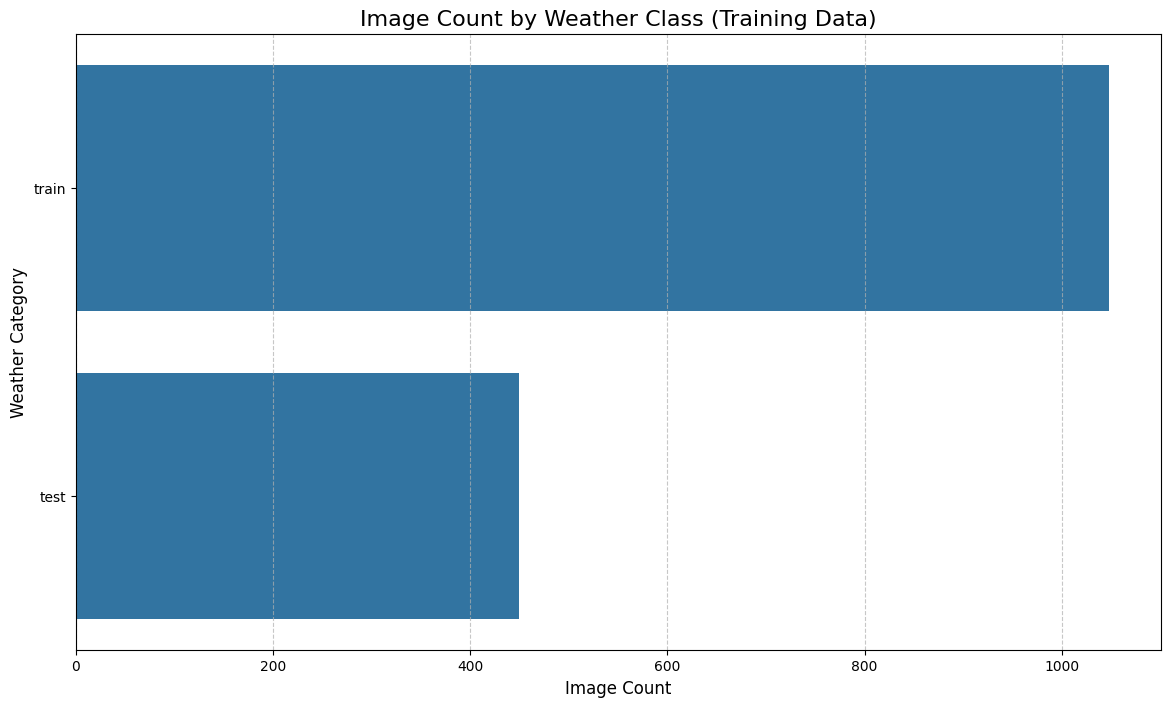


Analysis: Check for any significant class imbalance.


In [7]:
#@title 4. [EDA 보강] 클래스 분포 확인 (Bar Plot - 영문)
# (데이터를 tf.data로 로드하기 전에, 디렉토리의 실제 파일 수를 먼저 카운트합니다.)

print("Analyzing class distribution in directory...")
try:
    class_paths = glob(os.path.join(DATASET_PATH, '*'))
    class_names_eng = sorted([os.path.basename(p) for p in class_paths if os.path.isdir(p)])
    NUM_CLASSES = len(class_names_eng)

    if NUM_CLASSES == 0:
        raise FileNotFoundError("No class subdirectories found in DATASET_PATH.")

    print(f"Found {NUM_CLASSES} classes:")
    print(class_names_eng)

    # 각 클래스별 이미지 개수 카운트
    class_counts = []
    for class_name in class_names_eng:
        count = len(os.listdir(os.path.join(DATASET_PATH, class_name)))
        class_counts.append(count)

    # 시각화를 위한 DataFrame 생성
    df_counts = pd.DataFrame({
        'ClassName': class_names_eng,
        'Count': class_counts
    }).sort_values(by='Count', ascending=False)

    # 클래스 분포 시각화
    plt.figure(figsize=(14, 8))
    sns.barplot(data=df_counts, y='ClassName', x='Count', orient='h')
    plt.title('Image Count by Weather Class (Training Data)', fontsize=16)
    plt.xlabel('Image Count', fontsize=12)
    plt.ylabel('Weather Category', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

    print("\nAnalysis: Check for any significant class imbalance.")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print(f"Please ensure DATASET_PATH ('{DATASET_PATH}') is correct and contains subdirectories for each class.")
except Exception as e:
    print(f"An error occurred: {e}")

Found 1498 files belonging to 2 classes.
Using 1199 files for training.
Found 1498 files belonging to 2 classes.
Using 299 files for validation.

Class names loaded by TensorFlow:
['test', 'train']

Displaying sample images from the training dataset...


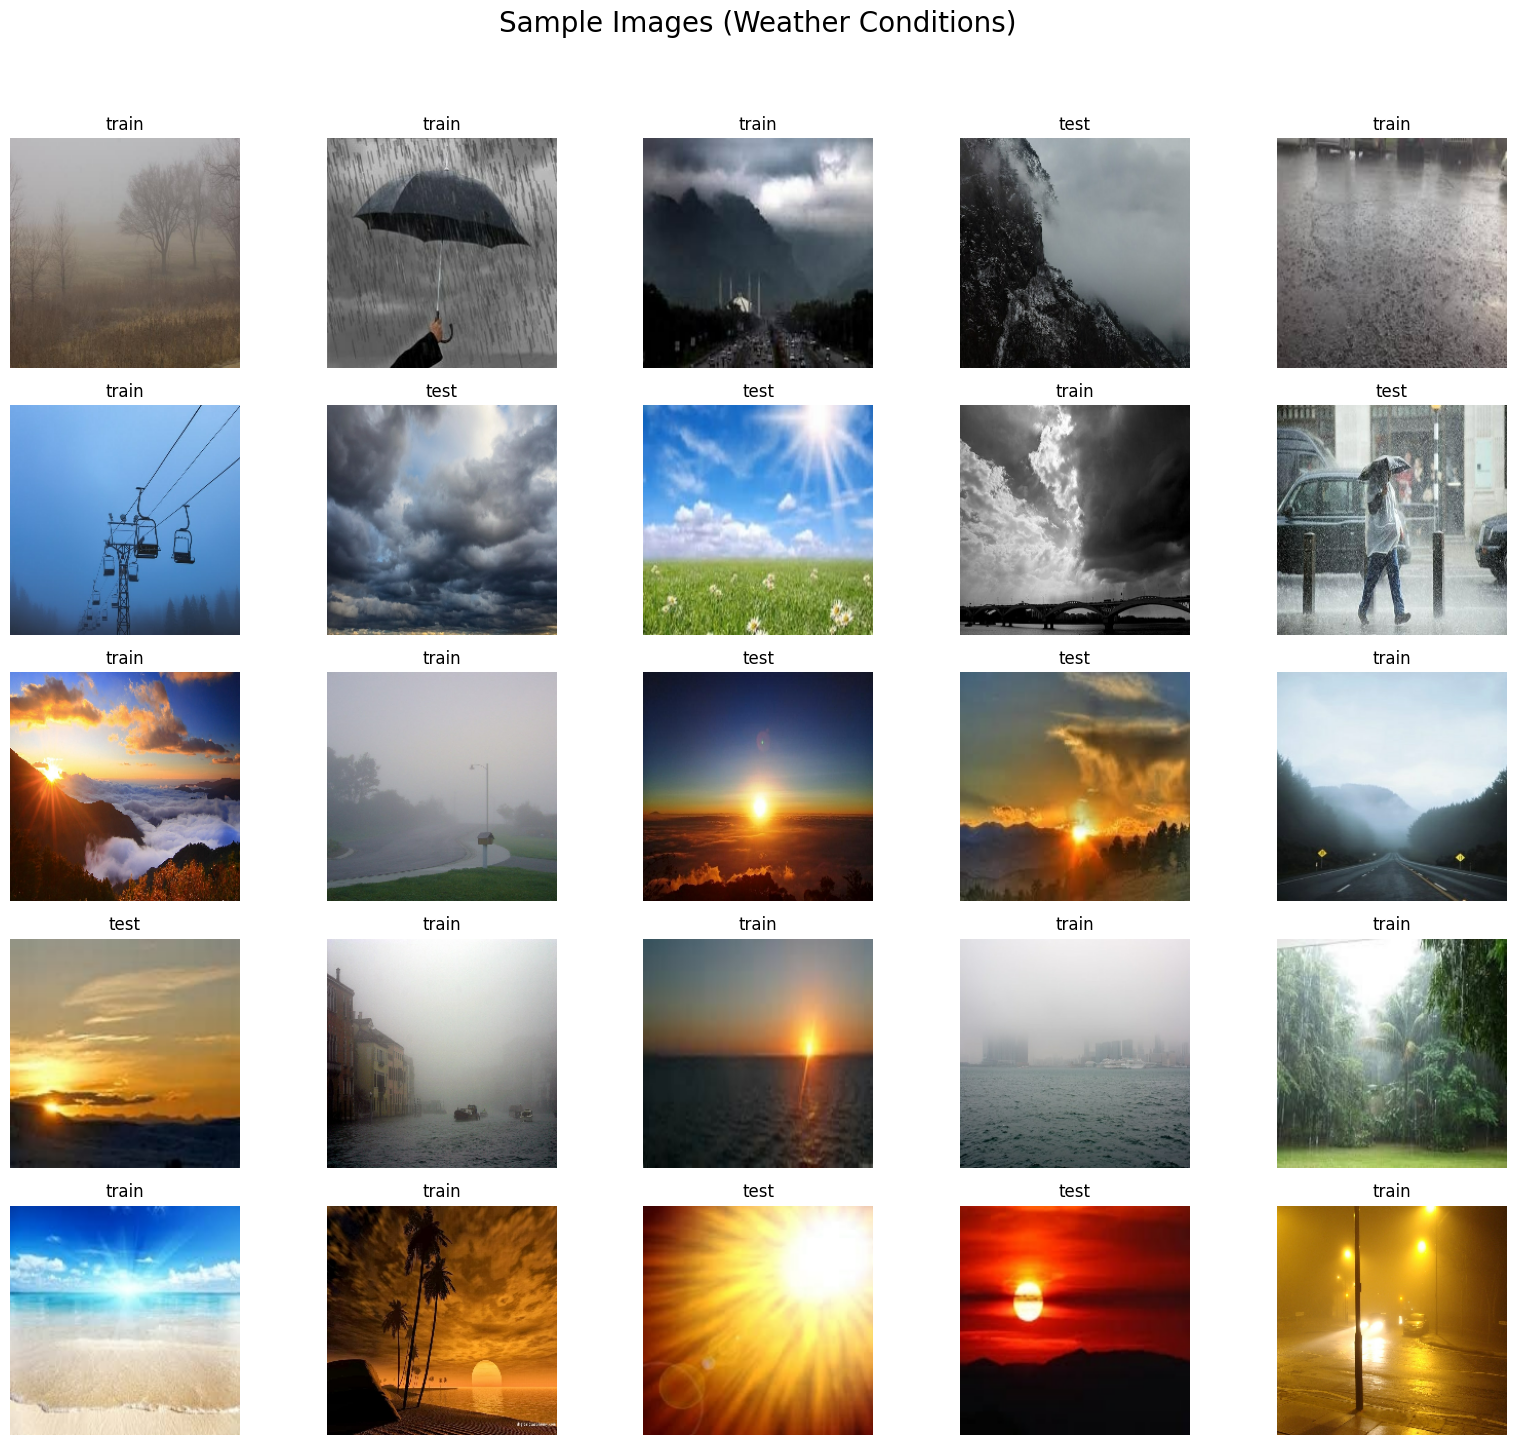

In [9]:
#@title 5. 데이터 로드 및 분리 (tf.data Pipeline)

# 1. 훈련 데이터셋 (Training Dataset) 로드 (전체의 80%)
try:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH,
        validation_split=VALIDATION_SPLIT,
        subset="training",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    # 2. 검증 데이터셋 (Validation Dataset) 로드 (전체의 20%)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH,
        validation_split=VALIDATION_SPLIT,
        subset="validation",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    # 클래스 이름 확인 (영문)
    class_names = train_ds.class_names
    print("\nClass names loaded by TensorFlow:")
    print(class_names)

except Exception as e:
    print(f"\nError loading dataset: {e}")
    print("This often happens if the DATASET_PATH is incorrect or the directory is empty.")


#@title 6. [EDA 보강] 샘플 이미지 시각화 (Image Grid - 영문)

print("\nDisplaying sample images from the training dataset...")
plt.figure(figsize=(16, 16))
plt.suptitle('Sample Images (Weather Conditions)', fontsize=20, y=0.93)

# 훈련 데이터셋에서 1개의 배치(32개 이미지)를 가져옵니다.
for images, labels in train_ds.take(1):
    for i in range(min(25, BATCH_SIZE)): # 최대 25개(5x5)만 표시
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]]) # 영문 클래스 이름
        plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()


In [10]:
#@title 7. 데이터 증강(Augmentation) 레이어 정의 및 최적화

# 1. 데이터 증강 레이어 정의 (Sequential API 사용)
data_augmentation = Sequential([
    RandomFlip("horizontal", seed=SEED),
    RandomRotation(0.1, seed=SEED), # 10% 범위 내에서 랜덤 회전
], name="data_augmentation")


In [11]:
# 2. 데이터셋 파이프라인 구성 (성능 최적화: prefetch, cache)

# 훈련 데이터셋 (Augmentation 적용)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=BUFFER_SIZE)
# 참고: EfficientNet은 preprocess_input 함수 대신 Rescaling(1./255) 레이어를 모델 내에 포함하거나,
# 0-255 픽셀 그대로 입력받는 것을 권장합니다. 여기서는 모델의 일부로 증강 레이어를 추가합니다.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=BUFFER_SIZE)

# 검증 데이터셋 (Augmentation 미적용)
val_ds = val_ds.cache().prefetch(buffer_size=BUFFER_SIZE)

print("\nData pipelines configured with augmentation (train only) and optimization.")




Data pipelines configured with augmentation (train only) and optimization.


In [12]:
#@title 8. EfficientNetB0 전이 학습(Transfer Learning) 모델 구축

# 1. 사전 학습된 기본 모델(Base Model) 로드 (EfficientNetB0)
# include_top=False: 분류기 레이어(최상층)는 제외하고 특징 추출기만 가져옵니다.
base_model = EfficientNetB0(
    input_shape=IMG_SIZE + (3,), # (224, 224, 3)
    include_top=False,
    weights='imagenet' # ImageNet으로 사전 학습된 가중치 사용
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# 2. 기본 모델의 가중치 동결 (Freeze)
base_model.trainable = False

In [14]:
# 3. 새로운 분류기(Classifier) 정의 (Functional API 사용)
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
# (참고: EfficientNetB0는 입력값이 0-255 범위일 것을 기대합니다.)
# (데이터 증강 레이어를 모델의 일부로 포함할 수도 있습니다.)
x = base_model(inputs, training=False) # (training=False: BN 레이어가 추론 모드로 동작)
x = GlobalAveragePooling2D()(x) # 특징 맵을 벡터로 변환
x = Dropout(0.3)(x) # 과적합 방지 (Dropout 비율은 튜닝 대상)
outputs = Dense(NUM_CLASSES, activation='softmax')(x) # 11개 클래스 출력

In [15]:
# 4. 최종 모델 결합
model = Model(inputs, outputs)

# 5. 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', # (라벨이 정수형이므로 'sparse_' 사용)
    metrics=['accuracy']
)

# 모델 요약
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [16]:
#@title 9. 모델 학습 (Early Stopping 적용)

# 과적합 방지 및 최적 모델 저장을 위한 EarlyStopping 콜백
early_stopper = EarlyStopping(
    monitor='val_loss', # 검증 손실(val_loss)을 모니터링
    patience=5,         # 5 에포크 동안 개선되지 않으면 중지
    verbose=1,
    restore_best_weights=True # 가장 성능이 좋았던 시점의 가중치로 복원
)

print("\nStarting model training (using EfficientNetB0 base)...")

# 훈련 데이터(train_ds)에는 증강이 적용되어 있고 (map),
# 검증 데이터(val_ds)에는 증강이 적용되지 않았습니다.
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopper]
)

print("\nModel training finished.")



Starting model training (using EfficientNetB0 base)...
Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6017 - loss: 0.6939 - val_accuracy: 0.7358 - val_loss: 0.6067
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6851 - loss: 0.6305 - val_accuracy: 0.7224 - val_loss: 0.5879
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6943 - loss: 0.5951 - val_accuracy: 0.7258 - val_loss: 0.5948
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7143 - loss: 0.5844 - val_accuracy: 0.6990 - val_loss: 0.6039
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7233 - loss: 0.5865 - val_accuracy: 0.7157 - val_loss: 0.5976
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7149 - loss: 0.5652 - val_accuracy: 0.7157 - val_loss: 0.5995
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7296 - loss: 0.5539 - val_accuracy: 0.7124 - val_loss: 0.6016
Epoch 7: early stopping
Restoring model weights from the


Plotting training history...


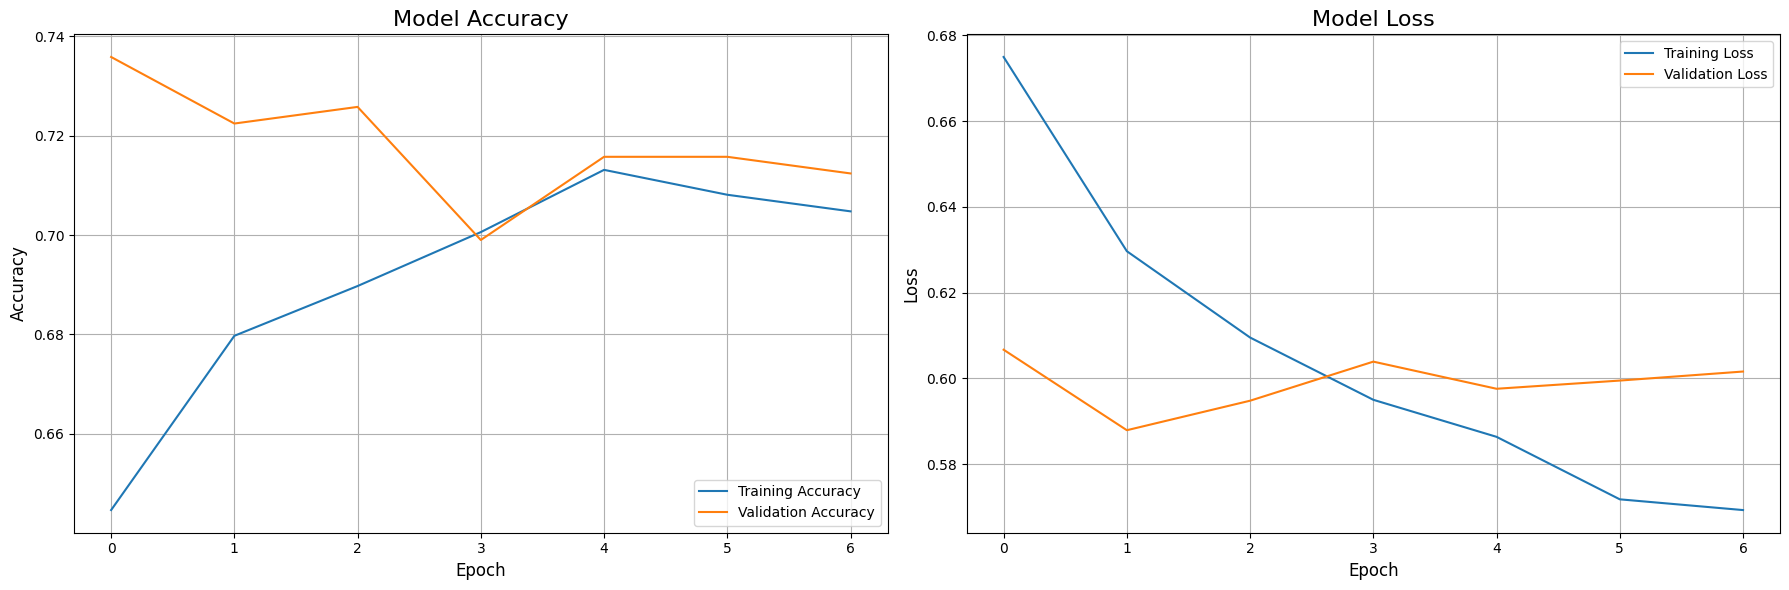

In [17]:
#@title 10. [결과 분석 보강] 학습 곡선 시각화 (Loss & Accuracy - 영문)

print("\nPlotting training history...")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Accuracy Plot (정확도)
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True)

# Loss Plot (손실)
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [18]:
#@title 11. [결과 분석 보강] 최종 평가: 분류 리포트 및 혼동 행렬 (영문)

print("\n--- Final Model Evaluation on Validation Set ---")

# 검증 데이터셋(val_ds) 전체에 대한 예측 수행
# (val_ds는 증강(augmentation)이 적용되지 않은 원본에 가까운 데이터입니다.)

# 1. 실제 라벨(y_true) 추출
y_true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# 2. 예측 라벨(y_pred) 생성
y_pred_probs = model.predict(val_ds)
y_pred_labels = np.argmax(y_pred_probs, axis=1) # 확률 -> 가장 높은 클래스 인덱스로 변환

# 3. 분류 리포트 (Classification Report)
print("\n[Classification Report (English)]")
# class_names는 Cell 5에서 tf.data가 로드한 영문 이름 리스트를 사용
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))



--- Final Model Evaluation on Validation Set ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 731ms/step

[Classification Report (English)]
              precision    recall  f1-score   support

        test       0.25      0.03      0.05        79
       train       0.74      0.97      0.84       220

    accuracy                           0.72       299
   macro avg       0.49      0.50      0.44       299
weighted avg       0.61      0.72      0.63       299




Plotting Confusion Matrix...


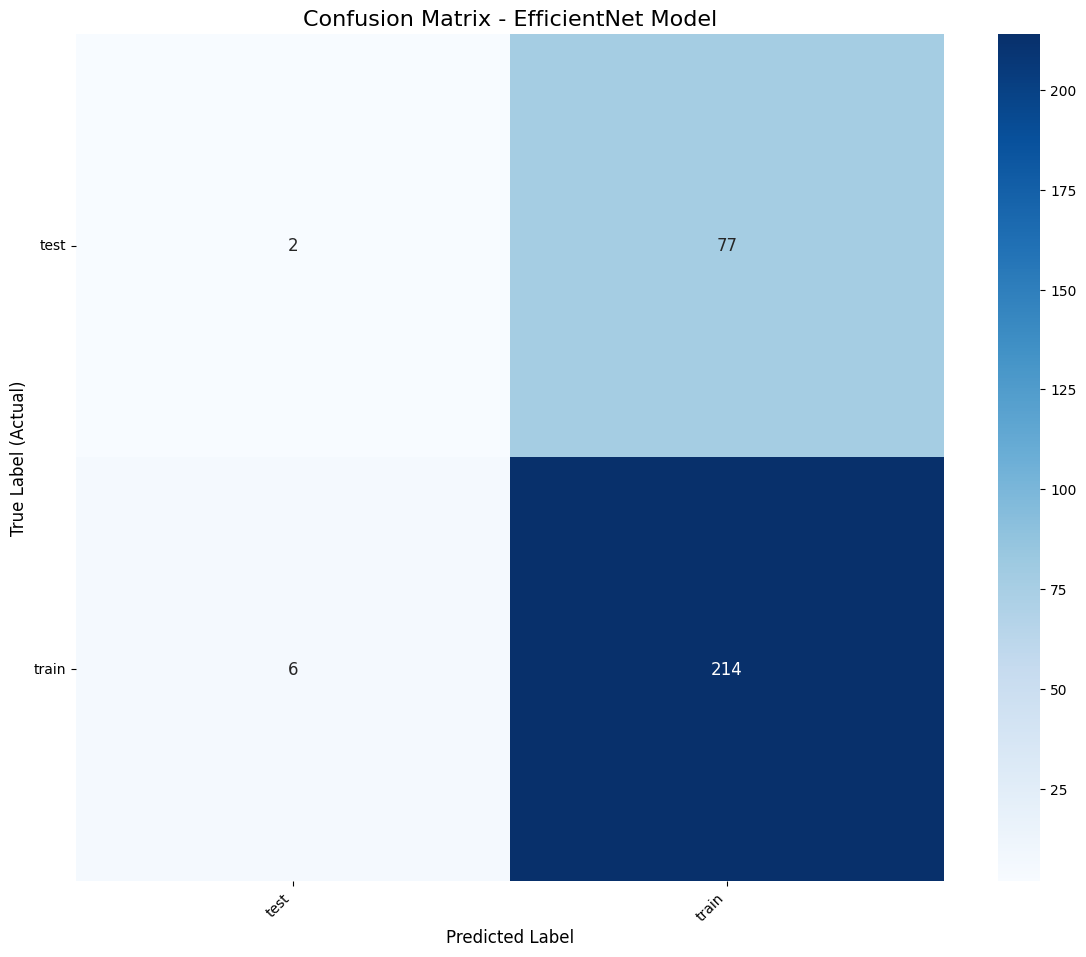

In [19]:
# 4. 혼동 행렬 (Confusion Matrix) 시각화
print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(14, 11)) # 클래스가 많으므로(11개) 플롯 크기를 키웁니다.
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 12})

plt.title('Confusion Matrix - EfficientNet Model', fontsize=16)
plt.ylabel('True Label (Actual)', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right') # X축 라벨 회전
plt.yticks(rotation=0)
plt.show()